<a href="https://colab.research.google.com/github/youkjang/Climate_Chage/blob/main/Threshold_Analysis_ExtremePr_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maryland Precipitation Threshold Analysis
- LOCA CMIP6 daily precipitation for Maryland
- Counts of how many days/year exceed a critical precipitataion threshold (>50mm/day)
- Compute and plot annual mean for extreme rain (time series)
- Spatial map of Extreme Days for some years



###Reference
- https://loca.ucsd.edu/loca-version-2-for-north-america-ca-jan-2023/
- shapefile for MD (MDOT SHA County Boundaries data)
: https://data.imap.maryland.gov/

In [1]:
!pip install cartopy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 60.8 MB/s eta 0:00:00


In [2]:
!pip install us --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 10.8 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
import us

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

###Load historical & future daily precipitation

In [5]:
filename = 'pr.GFDL-CM4.historical.MD.nc'
filename1 = 'pr.GFDL-CM4.ssp245.MD.nc'
filename2 = 'pr.GFDL-CM4.ssp585.MD.nc'

In [6]:
ds = xr.open_dataset(filename)
ssp245 = xr.open_dataset(filename1)
ssp585 = xr.open_dataset(filename2)

In [7]:
ds1 = xr.concat([ds, ssp245],dim='time')
ds2 = xr.concat([ds, ssp585],dim='time')

###Load and transform spatial data
- convert the coordinaters of the county boundaries into the standard latitude and longitude system

In [8]:
gdf = gpd.read_file('MDOT_SHA_County_Boundaries.zip')
gdf = gdf.to_crs("EPSG:4326")

In [10]:
ds1

<xarray.Dataset> Size: 530MB
Dimensions:  (time: 55152, lat: 30, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 441kB 1950-01-01T12:00:00 ... 2100-12-31T1...
  * lon      (lon) float64 640B 280.0 280.1 280.2 280.2 ... 284.8 284.9 285.0
  * lat      (lat) float64 240B 38.16 38.22 38.28 38.34 ... 39.84 39.91 39.97
Data variables:
    pr       (time, lat, lon) float32 529MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

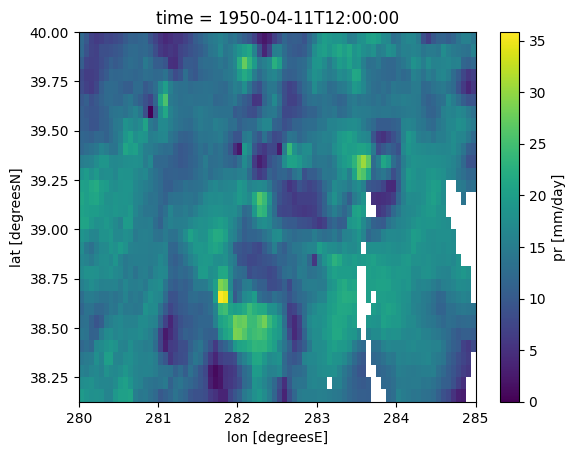

In [11]:
ds.isel(time=100).pr.plot()

###Apply Threshold: Days > 50 mm/day

In [12]:
threshold = 50
extreme_rain = ds > threshold
extreme_rain1 = ds1 > threshold
extreme_rain2 = ds2 > threshold



###Count Extreme Rain Days per Year

In [15]:
extreme_rain_annual = extreme_rain.groupby('time.year').sum(dim='time')
extreme_rain_annual1 = extreme_rain1.groupby('time.year').sum(dim='time')
extreme_rain_annual2 = extreme_rain2.groupby('time.year').sum(dim='time')

###Plot Time Series of Spatial Average

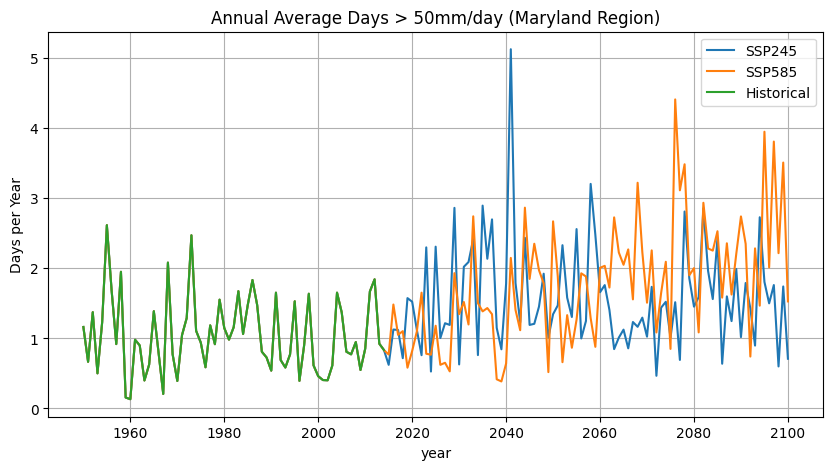

In [18]:
regional_avg = extreme_rain_annual['pr'].mean(dim=['lat', 'lon'])
regional_avg1 = extreme_rain_annual1['pr'].mean(dim=['lat', 'lon'])
regional_avg2 = extreme_rain_annual2['pr'].mean(dim=['lat', 'lon'])

plt.figure(figsize=(10, 5))
regional_avg1.plot(label='SSP245')
regional_avg2.plot(label='SSP585')
regional_avg.plot(label='Historical')
plt.legend()
plt.title(f"Annual Average Days > {threshold}mm/day (Maryland Region)")
plt.ylabel("Days per Year")
plt.grid(True)
plt.show()

###Plot Spatial Map for One Year

In [30]:
def plot_threshold_map(year, ssp):


      fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

      year_to_plot = year
      if ssp == 'Historical':
        data_to_plot = extreme_rain_annual
      elif ssp == 'SSP245':
        data_to_plot = extreme_rain_annual1
      elif ssp == 'SSP585':
        data_to_plot = extreme_rain_annual2

      data_to_plot['pr'].sel(year=year_to_plot).plot(
          cmap='Blues',levels=20, vmin=0, vmax=5,
          cbar_kwargs={'label': f'Days > {threshold}mm'},
          robust=True
      )


      # Plot shapefile on top
      gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
      # Add text labels from the 'COUNTY' column
      for i, row in gdf.iterrows():
          x, y = row.geometry.centroid.x, row.geometry.centroid.y  # Use centroid for better placement
          name = row['COUNTY']  # Replace 'COUNTY' if your name column is different
          ax.text(x, y, name, fontsize=8, ha='center', va='center') #Center the text

      #ax.coastlines()
      #ax.add_feature(cfeature.BORDERS, linestyle=':')
      #x.set_title('SSP245 Projected Temperature Change (2000-2010 vs 2040-2050)')

      plt.title(ssp+f"   Extreme Rainfall Days in {year_to_plot}")
      plt.show()

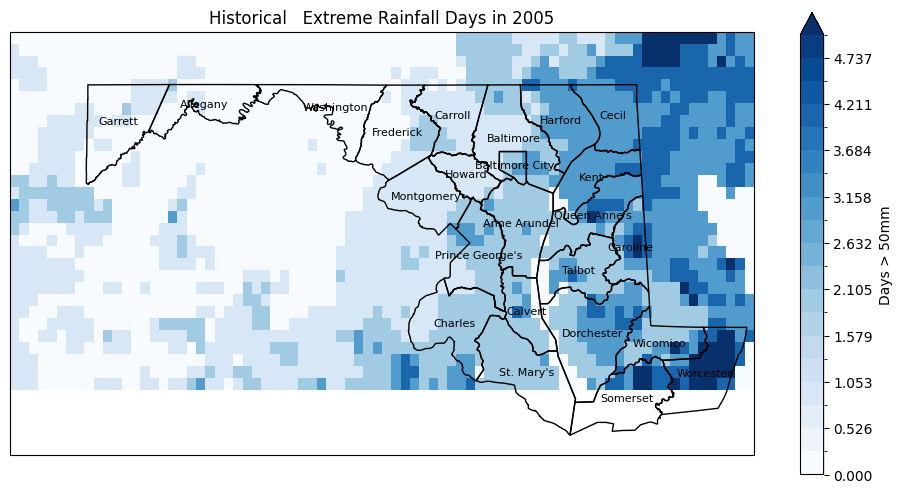

In [42]:
plot_threshold_map(2005,'Historical')

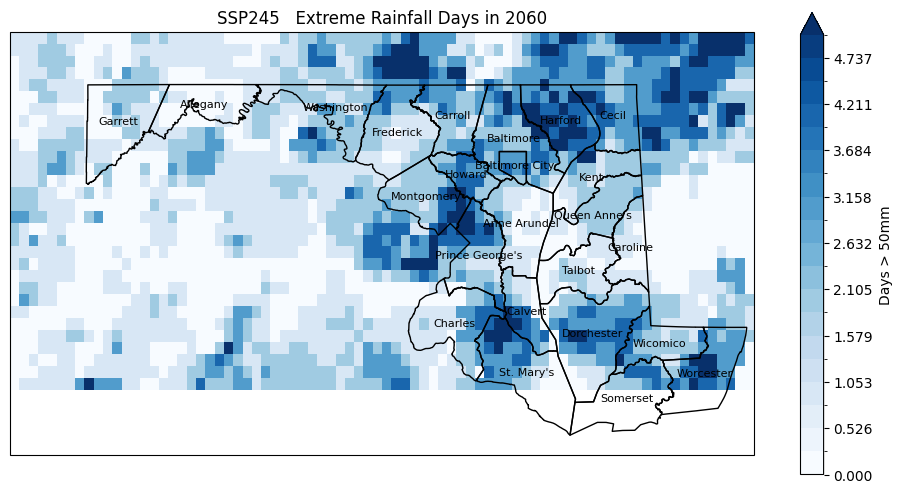

In [40]:
plot_threshold_map(2060,'SSP245')

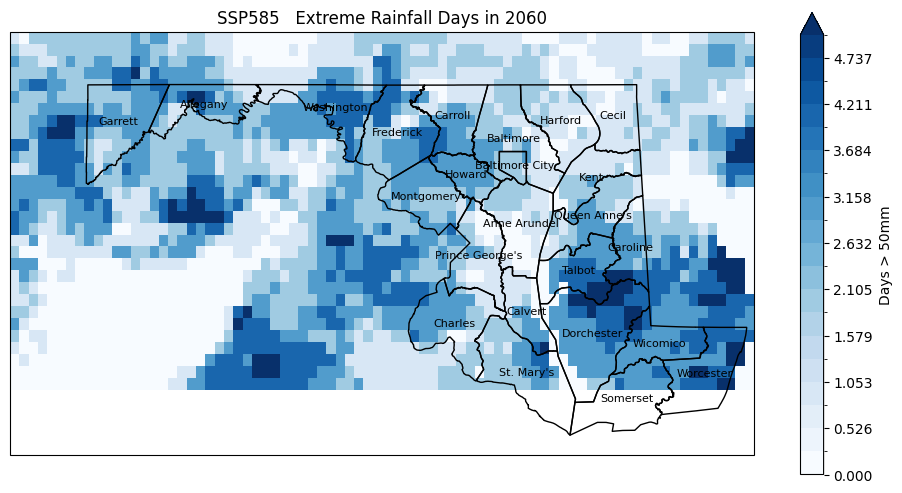

In [41]:
plot_threshold_map(2060,'SSP585')